# Step 2a: Filtering en-route

## Import required libraries

In [ ]:
import glob
import polars as pl
import pandas as pd
import numpy as np

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties

from multiprocessing import Pool
from traffic.core import Traffic, Flight

# Set cmr10 globally
plt.rcParams.update({
    'text.usetex': False,
    'axes.formatter.use_mathtext' : True,
    'font.family': 'cmr10',
    'font.size': 13,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.dpi': 150
})

## Retrieve Preprocessed Data

In [2]:
files = glob.glob('/store/fusg/VT1/trajectory_data/*.parquet')

df = pl.read_parquet(files).to_pandas()
trajs = Traffic(df)
print(f"Total preprocessed Flights: {len(trajs)}")

Total preprocessed Flights: 379409


## Filter en-route trajectories

In [3]:
def filter_enroute_segments(
    f: Flight,
    min_altitude: int = 19500,
    min_length: int = 72,
    max_interp_gap: int = 2,
):
    if f.data["typecode"].isna().any():
        return []

    numeric = ["latitude","longitude","track",
               "altitude","groundspeed","vertical_rate"]
    cols = ["timestamp","icao24","flight_id", "callsign", "typecode"] + numeric
    df = f.data[cols].copy()

    df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.floor("s")

    df = (df
          .set_index("timestamp")
          .sort_index()
          .resample("1s")
          .asfreq())

    df["icao24"]    = df["icao24"].ffill().bfill()
    df["flight_id"] = df["flight_id"].ffill().bfill()
    df["callsign"] = df["callsign"].ffill().bfill()

    df[numeric] = df[numeric].interpolate(
        method="linear",
        limit=max_interp_gap,
        limit_direction="both"
    )

    df = df.dropna(subset=numeric)
    # if is_noisy(f, change_frac_thresh=0.25):
    #     return []

    df = df[df["altitude"] >= min_altitude]
    if df.empty:
        return []
    
    alt = df["altitude"].to_numpy()
    if len(alt) > 1:
        if np.max(np.abs(np.diff(alt))) > 75:
            return []

    en = Flight(df.reset_index(), callsign=f.flight_id)
    segments = en.split(1,"s")

    return [seg for seg in segments if len(seg.data) >= min_length]

def get_all_enroute_segments(trajs, n_processes=48):
    with Pool(n_processes) as pool:
        for result in tqdm(pool.imap_unordered(filter_enroute_segments, trajs), total=len(trajs), desc="Extracting enroute segments"):
            for seg in result:
                yield seg

t_enroute = Traffic.from_flights(get_all_enroute_segments(trajs))
print(f"Total enroute segments: {len(t_enroute)}")

Extracting enroute segments:   0%|          | 0/379409 [00:04<?, ?it/s]

Total enroute segments: 180519


In [4]:
# --- Plotting Logic ---
MIN_ALTITUDE = 19500 # feet
MIN_LENGTH = 72     # seconds
GAP = 1             # second

raw_flight_for_plot = None
extracted_segment_for_plot = None

# Find a suitable flight and an extracted segment for plotting
print("\nSearching for a suitable flight example for plotting...")
for flight in tqdm(trajs, desc="Finding example flight"):
    segments = filter_enroute_segments(flight, min_altitude=MIN_ALTITUDE, min_length=MIN_LENGTH, max_interp_gap=GAP)
    if segments:
        raw_flight_for_plot = flight
        # Prioritize a longer segment for better visual representation
        extracted_segment_for_plot = max(segments, key=lambda seg: len(seg.data))
        break


Searching for a suitable flight example for plotting...


Finding example flight:   0%|          | 0/379409 [00:00<?, ?it/s]

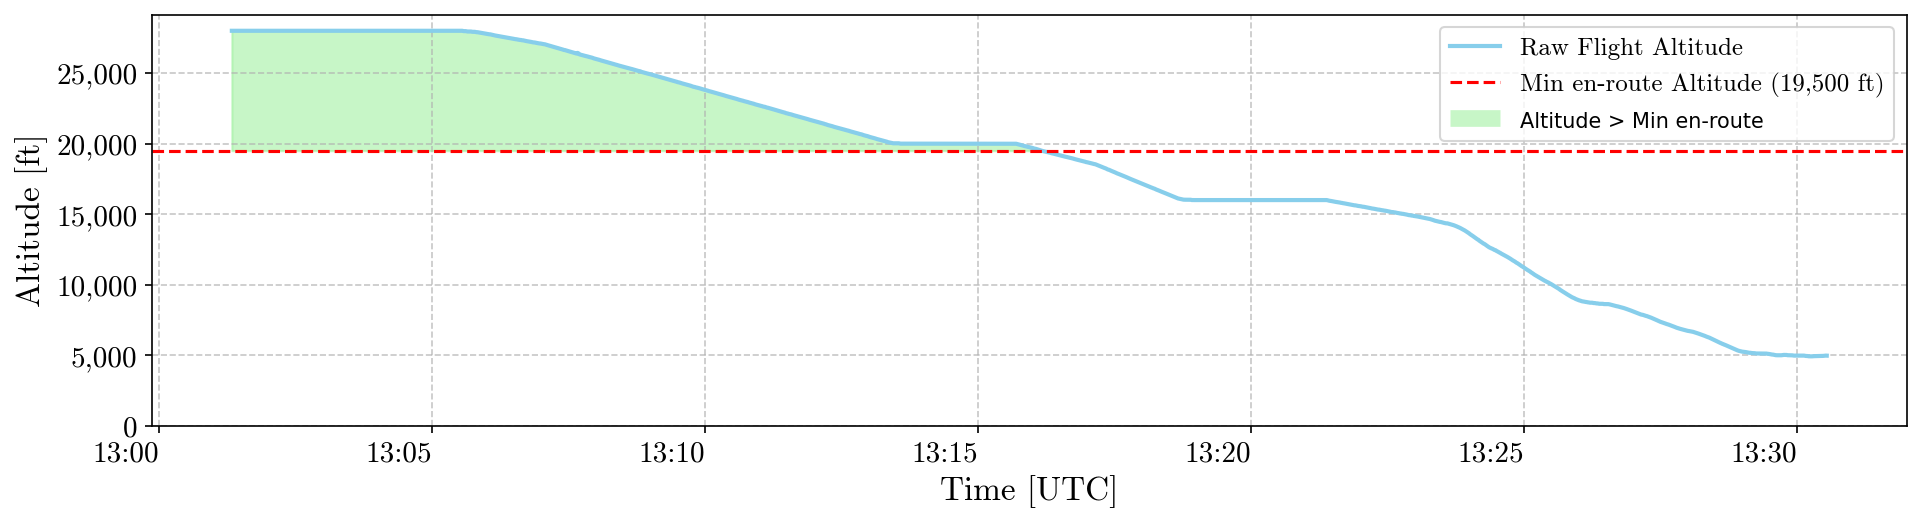

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 4))

# --- Plot the Raw Flight Altitude Profile ---
ax.plot(raw_flight_for_plot.data["timestamp"], raw_flight_for_plot.data["altitude"],
            label='Raw Flight Altitude', color='skyblue', linewidth=2.0, alpha=1.0)

# Mark the min_altitude threshold
ax.axhline(y=MIN_ALTITUDE, color='red', linestyle='--',
            label='Min en-route Altitude (19,500 ft)')

# Highlight all points above min_altitude in green (regardless of gaps)
enroute_indices = raw_flight_for_plot.data["altitude"] >= MIN_ALTITUDE
fill = ax.fill_between(
    raw_flight_for_plot.data["timestamp"],
    19500, # Fill from the bottom of the plot
    raw_flight_for_plot.data["altitude"],
    where=enroute_indices,
    color='lightgreen',
    alpha=0.5
)

# Format x-axis to show only hour and minute
formatter = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
fig.autofmt_xdate(rotation=0) # Rotate labels for better readability

import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# --- Labels and Title ---
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Altitude [ft]')
ax.grid(True, linestyle='--', alpha=0.7)

# Custom legend: use DejaVu Sans for the '>' label only
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color='skyblue', linewidth=2.0, label='Raw Flight Altitude'),
    Line2D([0], [0], color='red', linestyle='--', label='Min en-route Altitude (19,500 ft)'),
    Line2D([0], [0], color='lightgreen', linewidth=8, alpha=0.5, label='Altitude > Min en-route',
           solid_capstyle='butt')
]
legend_labels = [
    'Raw Flight Altitude',
    'Min en-route Altitude (19,500 ft)',
    'Altitude > Min en-route'
]
legend_fonts = [
    FontProperties(family='cmr10', size=12),
    FontProperties(family='cmr10', size=12),
    FontProperties(family='DejaVu Sans', size=10)
]
leg = ax.legend(legend_handles, legend_labels, fontsize=12, loc='best', frameon=True)
for text, font in zip(leg.get_texts(), legend_fonts):
    text.set_fontproperties(font)

ax.set_ylim(bottom=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

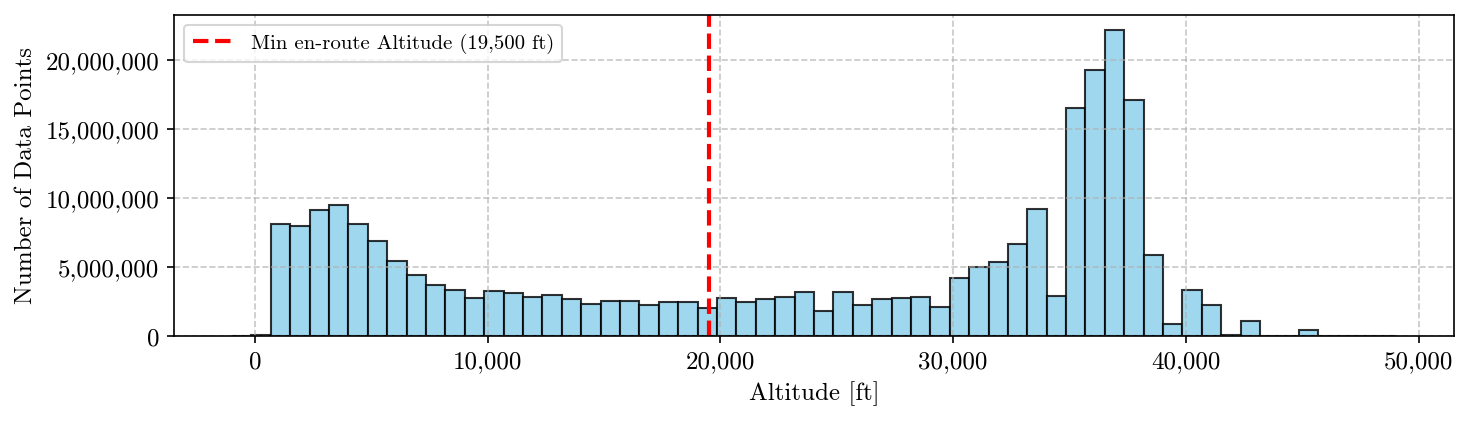

In [ ]:
# Distribution of Flight Altitudes (Overall Data)

# Use all altitude values from the full dataset
df_altitudes = df["altitude"].dropna().to_numpy()

fig, ax = plt.subplots(figsize=(10, 3))

# Plot histogram
n, bins, patches = ax.hist(df_altitudes, bins=60, color='skyblue', edgecolor='black', alpha=0.8)

# Mark the min_altitude threshold
ax.axvline(MIN_ALTITUDE, color='red', linestyle='--', linewidth=2, label=f'Min en-route Altitude (19,500 ft)')

import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Labels and title
ax.set_xlabel('Altitude [ft]', fontsize=12)
ax.set_ylabel('Number of Data Points', fontsize=12)
#ax.set_title('Distribution of Flight Altitudes (Overall Data)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Examining Aircraft typecode

In [29]:
df = pd.read_parquet(
    f"/store/fusg/VT1/training/v4/traffic_enroute_filtered.parquet"
)
df = df.loc[:, ~df.columns.str.startswith("__index_level_")]
t_enroute = Traffic(df)
print(f"Total en-route segments: {len(t_enroute)}")

Total en-route segments: 180514


In [30]:
n = 1500

# Prepare data
typecodes = []
for flight in t_enroute:
    if not flight.data.empty and 'typecode' in flight.data.columns:
        tc = flight.data['typecode'].iloc[0]
        if pd.notna(tc):
            typecodes.append(tc)

df_typecodes = pd.DataFrame({'typecode': typecodes})
counts = df_typecodes['typecode'].value_counts()
frequent_types = counts[counts > n].index.tolist()

counts = counts[counts > n].sort_values(ascending=False)
print(f"Frequent typecodes (count > {n}):", frequent_types)

Frequent typecodes (count > 1500): ['A320', 'B738', 'A319', 'A20N', 'A321', 'B38M', 'BCS3', 'A21N', 'B77W', 'E190', 'B789', 'A333', 'E195', 'A359', 'PC12', 'BCS1']


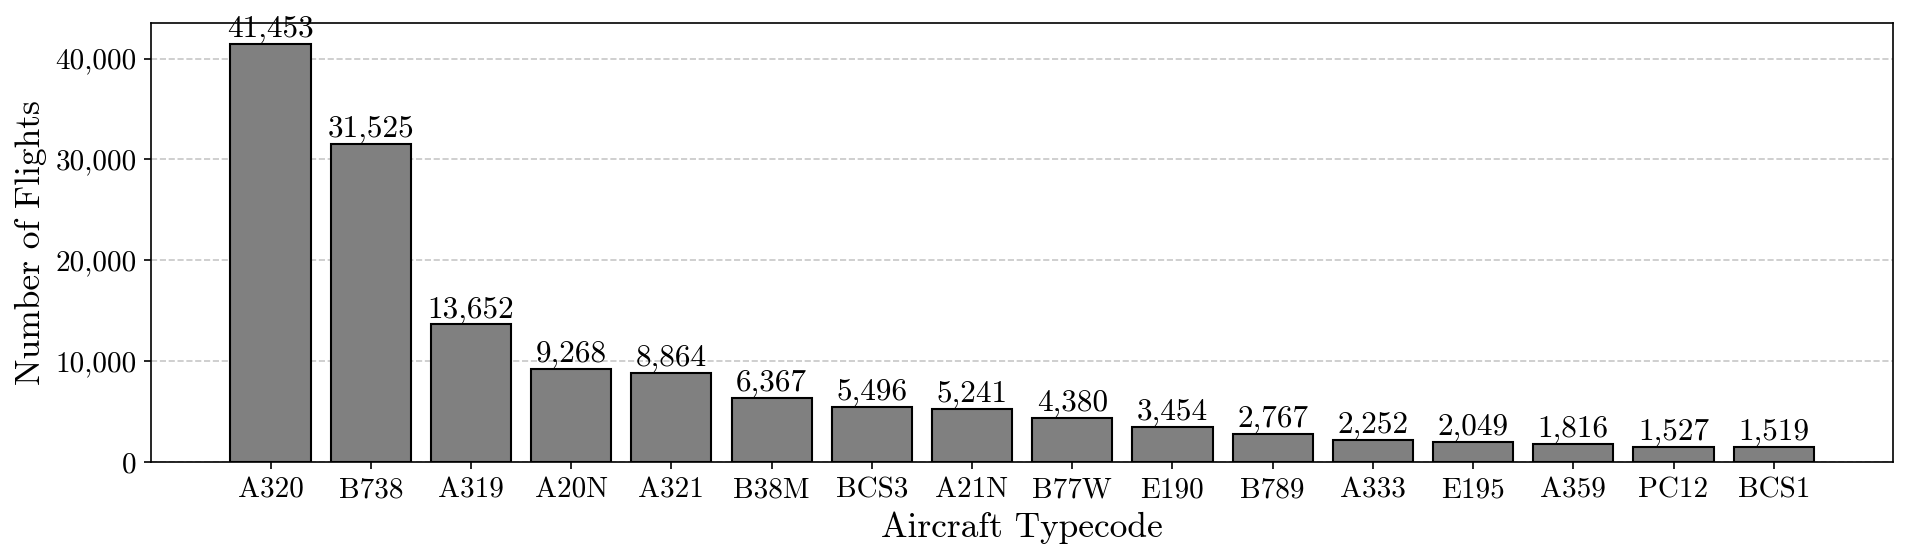

In [36]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'cmr10',
    'font.size': 16,
    'axes.labelsize': 17,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.dpi': 150
})

# Create figure
fig, ax = plt.subplots(figsize=(13, 4))
bars = ax.bar(counts.index, counts.values, color='gray', edgecolor='black')
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0.5),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=15)

import matplotlib.ticker as mticker
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add labels and title
ax.set_xlabel('Aircraft Typecode')
ax.set_ylabel('Number of Flights')
#ax.set_title('Most Frequent Aircraft Typecodes')

plt.tight_layout()
plt.show()

## Final save

In [ ]:
# Save t_enroute as traff filtered in store cluster as well as frequent typecodes
version = "v4"

# v1 : original, no gap interpolation
# v2 : remove change > 0.25, gap interpolation
# v3 : no change removed, gap interpolation
# v4 : no change removed, no gap interpolation, min length 72s, min altitude 19500ft

# 1) Turn your final Traffic back into a pandas DataFrame
df = t_enroute.data

# 2) Drop any unwanted index columns
df = df.reset_index(drop=True)
df = df.drop(columns=[c for c in df.columns if c.startswith('__index_level_')])

# 3) Write via pandas, which promotes string columns to large strings
out_path = f"/store/fusg/VT1/training/{version}/traffic_enroute_filtered.parquet"
df.to_parquet(out_path, index=False)

np.save(f"/store/fusg/VT1/training/{version}/frequent_typecodes.npy", frequent_types)

In [60]:
df = df.loc[:, ~df.columns.str.startswith("__index_level_")]
t_enroute = Traffic(df)
print(f"Total en-route segments: {len(t_enroute)}")

Total en-route segments: 180519


In [ ]:
t_enroute.data.columns

Index(['timestamp', 'icao24', 'flight_id', 'callsign', 'typecode', 'latitude',
       'longitude', 'track', 'altitude', 'groundspeed', 'vertical_rate'],
      dtype='object')